In [38]:
import blackjax
from flax import linen as nn  # The Linen API
from flax.core.frozen_dict import unfreeze

import jax
import jax.numpy as jnp  # JAX NumPy

from jax import tree_map 
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
from probml_utils.blackjax_utils import inference_loop

%matplotlib inline
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import seaborn as sns
from sklearn.datasets import make_moons

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import os
os.chdir("../../")
from utilities.plot import plot_binary_class
from models.mlp import bnn
os.chdir("notebooks/classification")

In [39]:
X,Y =  make_moons(200, noise=0.2, random_state=1) # create dataset using sklearn

X.shape,Y.shape

((200, 2), (200,))

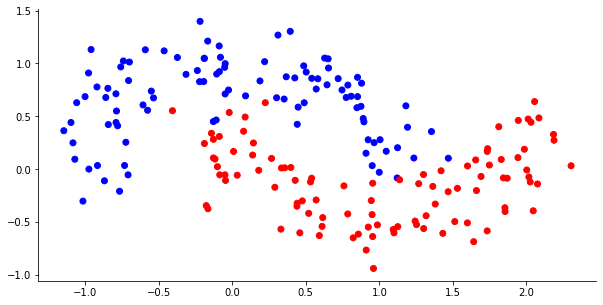

In [40]:
plt.figure(figsize=[10,5])
plt.scatter(X[:,0],X[:,1], c=Y, cmap='bwr')
sns.despine()

In [41]:
model = bnn([16, 32, 64, 32, 16, 1])

In [42]:
params = model.init(jax.random.PRNGKey(0), X)

In [43]:
Y.shape

(200,)

## Defining the log joint

In [44]:
def bnn_log_joint(params:dict, X, y, model:bnn):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model 
    X: shape-(n_samples,2) training points 
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """
    
    logits = model.apply(params, X).ravel()
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-5114.9272, dtype=float32)

In [21]:
num_warmup = 1000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)

key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)

In [22]:
num_samples = 500
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [23]:
infos.is_divergent.sum()

DeviceArray(19, dtype=int32)

Text(0.5, 1.0, 'params Dense_0 bias-0')

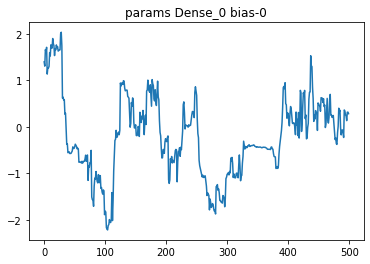

In [24]:
plt.plot(states.position['params']['0_Dense']['kernel'][:,1,10])
plt.title('params Dense_0 bias-0')

# Prediction using one test example

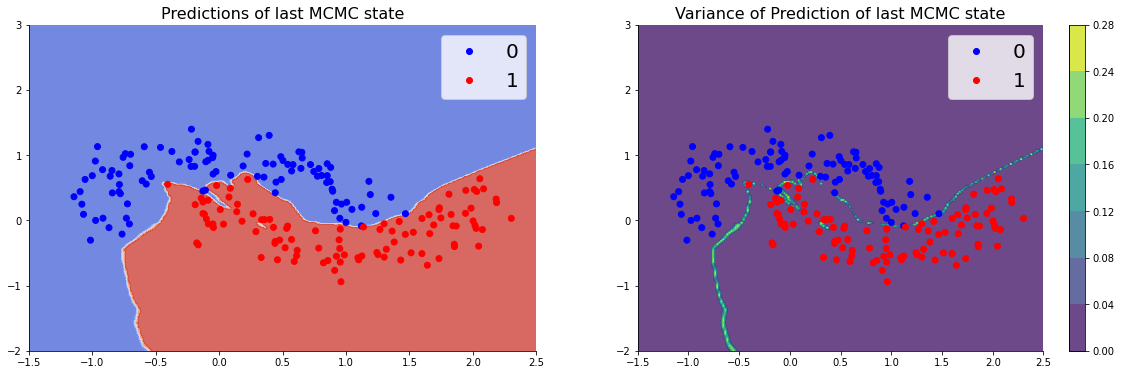

In [25]:
i=-1
params_last_state = tree_map(lambda x:x[i],states.position)
logits = model.apply(params_last_state, X)
y_pred = nn.sigmoid(logits)
y_hat = (y_pred >= 0.5).astype(int)

xx1 = jnp.linspace(-1.5, 2.5, 200)
xx2 = jnp.linspace(-2.0, 3, 200)
XX1, XX2 = jnp.meshgrid(xx1, xx2)

Z = nn.sigmoid(model.apply(params_last_state, jnp.c_[XX1.ravel(), XX2.ravel()]))
Z = Z.reshape(XX1.shape)
sigma_Z = Z*(1-Z)

plot_binary_class(X_scatters=X,y_scatters=y_hat,XX1_grid=XX1,XX2_grid = XX2,grid_preds_mean=Z,grid_preds_sigma= sigma_Z,titles=("Predictions of last MCMC state","Variance of Prediction of last MCMC state"))


# Predictions using all the states till now.

In [26]:
seed = jax.random.PRNGKey(0)
def one_step(carry, state):
    params_cur = state.position
    samples = tfd.Bernoulli(model.apply(params_cur,jnp.c_[XX1.ravel(), XX2.ravel()])).sample(seed=seed)
    return carry, samples
_, y_stacks = jax.lax.scan(one_step, None, states)

In [27]:
Z = jnp.array(y_stacks).mean(axis=0)
sigma_Z = jnp.array(y_stacks).std(axis=0)
Z = Z.reshape(XX1.shape)
sigma_Z = sigma_Z.reshape(XX1.shape)

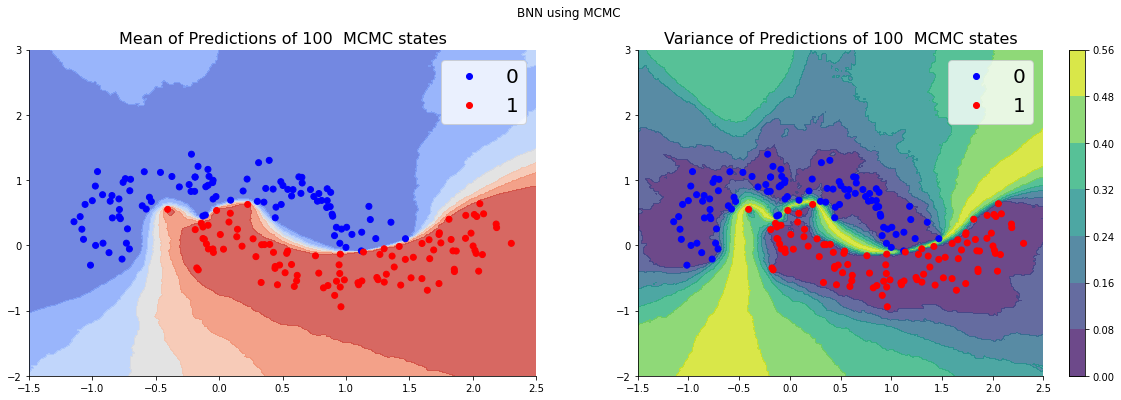

In [28]:
plot_binary_class(X_scatters=X,y_scatters=y_hat,XX1_grid=XX1,XX2_grid = XX2,grid_preds_mean=Z,grid_preds_sigma= sigma_Z,titles=("Mean of Predictions of 100  MCMC states","Variance of Predictions of 100  MCMC states"))
plt.suptitle("BNN using MCMC")
plt.savefig("BNN_MCMC.pdf")

In [29]:
import pickle
with open("make_moons",'wb') as f:
    pickle.dump({"states":states,"infos":infos},f)